# Baseline model

This file is for evaluation, the training and test sample generations are done in the CLI.

In [ ]:
# baseline configuration
# Configuration name: 3d_fullres
# {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 3, 'patch_size': [64, 128, 192], 'median_image_size_in_voxels': [59.0, 117.0, 180.5], 'spacing': [2.0, 0.732421875, 0.732421875], 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_seg_kwargs': {'is_seg': True, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'resampling_fn_probabilities': 'resample_data_or_seg_to_shape', 'resampling_fn_probabilities_kwargs': {'is_seg': False, 'order': 1, 'order_z': 0, 'force_separate_z': None}, 'architecture': {'network_class_name': 'dynamic_network_architectures.architectures.unet.PlainConvUNet', 'arch_kwargs': {'n_stages': 6, 'features_per_stage': [32, 64, 128, 256, 320, 320], 'conv_op': 'torch.nn.modules.conv.Conv3d', 'kernel_sizes': [[1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'strides': [[1, 1, 1], [1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], 'n_conv_per_stage': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'conv_bias': True, 'norm_op': 'torch.nn.modules.instancenorm.InstanceNorm3d', 'norm_op_kwargs': {'eps': 1e-05, 'affine': True}, 'dropout_op': None, 'dropout_op_kwargs': None, 'nonlin': 'torch.nn.LeakyReLU', 'nonlin_kwargs': {'inplace': True}}, '_kw_requires_import': ['conv_op', 'norm_op', 'dropout_op', 'nonlin']}, 'batch_dice': False}
# These are the global plan.json settings:
# {'dataset_name': 'Dataset001_PancreasSegClassification', 'plans_name': 'nnUNetPlans', 'original_median_spacing_after_transp': [2.0, 0.732421875, 0.732421875], 'original_median_shape_after_transp': [64, 119, 179], 'image_reader_writer': 'SimpleITKIO', 'transpose_forward': [0, 1, 2], 'transpose_backward': [0, 1, 2], 'experiment_planner_used': 'ExperimentPlanner', 'label_manager': 'LabelManager', 'foreground_intensity_properties_per_channel': {'0': {'max': 1929.0, 'mean': 74.06402587890625, 'median': 77.98674774169922, 'min': -406.9988098144531, 'percentile_00_5': -56.0, 'percentile_99_5': 179.99807739257812, 'std': 44.359100341796875}}}
# trained for 198 epochs

## Inference on Validation set to get the samples used for evaluation

In [1]:
import subprocess
import os

env_vars = os.environ.copy()
# print(root_dir)
env_vars['nnUNet_raw'] = "/mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_raw"
env_vars['nnUNet_preprocessed'] = "/mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_preprocessed"
env_vars['nnUNet_results'] = "/mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_results"

result = subprocess.run([
    "uv", "run", "--extra", "cu124",
    "nnUNetv2_predict",
    # "-pl", "nnUNetPlannerResEncM", # use without to use default planner
    "-i", "/mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_raw/Dataset001_PancreasSegClassification/imagesTs",
    "-o", "/mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_results/val_predictions",
    "-d", "1",
    "-c", "3d_fullres",
    "-f", "0",
    "-chk", "checkpoint_best.pth",
], env=env_vars, capture_output=True, text=True, check=True)

print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)


STDOUT: 
#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 36 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 36 cases that I would like to predict

Predicting quiz_074:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_074

Predicting quiz_080:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with quiz_080

Predicting quiz_084:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done w

## Evaluation on Segmentation (without the classification for now)

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
import json
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
import warnings
warnings.filterwarnings('ignore')

# Set paths - MODIFY THESE ACCORDING TO YOUR SETUP
PRED_FOLDER = "nnunet_data/nnUNet_results/Dataset001_PancreasSegClassification/val_predictions"  # Your prediction folder
GT_VALIDATION_FOLDER = "nnunet_data/nnUNet_raw/Dataset001_PancreasSegClassification"  # Ground truth validation folder
OUTPUT_DIR = "nnunet_data/nnUNet_results/Dataset001_PancreasSegClassification/val_predictions/evaluation_results"

# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)

print("Setup complete!")
print(f"Predictions folder: {PRED_FOLDER}")
print(f"Ground truth folder: {GT_VALIDATION_FOLDER}")

Setup complete!
Predictions folder: nnunet_data/nnUNet_results/val_predictions
Ground truth folder: nnunet_data/nnUNet_raw/Dataset001_PancreasSegClassification


In [3]:
def compute_dice_coefficient(y_true, y_pred):
    """Compute Dice coefficient between two binary masks"""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    if union == 0:
        return 1.0 if np.sum(y_true) == np.sum(y_pred) == 0 else 0.0
    return (2.0 * intersection) / union

def compute_hausdorff_distance(y_true, y_pred, spacing=(1.0, 1.0, 1.0)):
    """Compute Hausdorff distance between two binary masks"""
    try:
        # Get surface points using erosion
        true_surface = np.argwhere(ndimage.binary_erosion(y_true) != y_true)
        pred_surface = np.argwhere(ndimage.binary_erosion(y_pred) != y_pred)

        if len(true_surface) == 0 or len(pred_surface) == 0:
            return float('inf')

        # Apply spacing
        true_surface = true_surface * np.array(spacing)
        pred_surface = pred_surface * np.array(spacing)

        # Compute directed Hausdorff distances
        hd1 = directed_hausdorff(true_surface, pred_surface)[0]
        hd2 = directed_hausdorff(pred_surface, true_surface)[0]

        return max(hd1, hd2)
    except:
        return float('inf')

def compute_volume_metrics(y_true, y_pred, spacing=(1.0, 1.0, 1.0)):
    """Compute volume-based metrics"""
    voxel_volume = np.prod(spacing)
    true_volume = np.sum(y_true) * voxel_volume
    pred_volume = np.sum(y_pred) * voxel_volume

    if true_volume == 0:
        volume_error = pred_volume
    else:
        volume_error = abs(pred_volume - true_volume) / true_volume * 100

    return true_volume, pred_volume, volume_error

print("Helper functions defined!")

Helper functions defined!


In [11]:
# Create ground truth CSV for validation set if it doesn't exist
def create_validation_gt_csv():
    gt_csv_path = Path(OUTPUT_DIR) / "validation_ground_truth.csv"

    # Create ground truth CSV from folder structure
    validation_data = []
    df = pd.read_csv(Path(GT_VALIDATION_FOLDER) / "labels.csv")
    df = df[df['split'] == 'validation']  # Filter for validation split
    for index, row in df.iterrows():
        case_name = row['Photo ID']
        subtype_id = row['subtype']
        validation_data.append({'Names': case_name, 'Subtype': subtype_id})

    if validation_data:
        df = pd.DataFrame(validation_data)
        df.to_csv(gt_csv_path, index=False)
        print(f"Created ground truth CSV with {len(df)} cases: {gt_csv_path}")
        print(df.head())
    else:
        print("No validation data found in the specified folder structure")
        return None

    return gt_csv_path

# Create or load ground truth CSV
gt_csv_path = create_validation_gt_csv()

Created ground truth CSV with 36 cases: nnunet_data/nnUNet_results/val_predictions/evaluation_results/validation_ground_truth.csv
                  Names  Subtype
0  quiz_189_0000.nii.gz        0
1  quiz_171_0000.nii.gz        0
2  quiz_168_0000.nii.gz        0
3  quiz_244_0000.nii.gz        0
4  quiz_253_0000.nii.gz        0


In [15]:
def evaluate_segmentation_performance():
    """Evaluate segmentation performance on validation set"""
    results = []
    pred_folder = Path(PRED_FOLDER)

    # Find all prediction files
    pred_files = list(pred_folder.glob("*.nii.gz"))
    print(f"Found {len(pred_files)} prediction files")

    for pred_file in pred_files:
        case_id = pred_file.stem.replace('.nii', '')

        # Find corresponding ground truth file
        gt_file = Path(GT_VALIDATION_FOLDER) / "labelsTs" / f"{case_id}.nii.gz"

        if gt_file is None:
            print(f"Warning: No ground truth found for {case_id}")
            continue

        try:
            # Load images
            gt_img = nib.load(gt_file)
            pred_img = nib.load(pred_file)

            gt_data = gt_img.get_fdata().astype(np.uint8)
            pred_data = pred_img.get_fdata().astype(np.uint8)

            # Get spacing for physical distance metrics
            spacing = gt_img.header.get_zooms()

            # Whole pancreas (label 1 + label 2)
            gt_pancreas = (gt_data > 0).astype(np.uint8)
            pred_pancreas = (pred_data > 0).astype(np.uint8)

            # Lesion only (label 2)
            gt_lesion = (gt_data == 2).astype(np.uint8)
            pred_lesion = (pred_data == 2).astype(np.uint8)

            # Compute metrics
            pancreas_dice = compute_dice_coefficient(gt_pancreas, pred_pancreas)
            lesion_dice = compute_dice_coefficient(gt_lesion, pred_lesion)

            # Volume metrics
            pancreas_vol_gt, pancreas_vol_pred, pancreas_vol_error = compute_volume_metrics(
                gt_pancreas, pred_pancreas, spacing)
            lesion_vol_gt, lesion_vol_pred, lesion_vol_error = compute_volume_metrics(
                gt_lesion, pred_lesion, spacing)

            # Hausdorff distance (optional - can be slow)
            pancreas_hd95 = compute_hausdorff_distance(gt_pancreas, pred_pancreas, spacing)
            lesion_hd95 = compute_hausdorff_distance(gt_lesion, pred_lesion, spacing)

            results.append({
                'case_id': case_id,
                'pancreas_dice': pancreas_dice,
                'lesion_dice': lesion_dice,
                'pancreas_vol_gt': pancreas_vol_gt,
                'pancreas_vol_pred': pancreas_vol_pred,
                'pancreas_vol_error': pancreas_vol_error,
                'lesion_vol_gt': lesion_vol_gt,
                'lesion_vol_pred': lesion_vol_pred,
                'lesion_vol_error': lesion_vol_error,
                'pancreas_hd95': pancreas_hd95,
                'lesion_hd95': lesion_hd95
            })

            print(f"{case_id}: Pancreas DSC={pancreas_dice:.3f}, Lesion DSC={lesion_dice:.3f}")

        except Exception as e:
            print(f"Error processing {case_id}: {e}")
            continue

    return pd.DataFrame(results)

# Run segmentation evaluation
seg_results_df = evaluate_segmentation_performance()

Found 36 prediction files
quiz_241: Pancreas DSC=0.964, Lesion DSC=0.851
quiz_254: Pancreas DSC=0.935, Lesion DSC=0.510
quiz_253: Pancreas DSC=0.941, Lesion DSC=0.640
quiz_213: Pancreas DSC=0.948, Lesion DSC=0.848
quiz_158: Pancreas DSC=0.925, Lesion DSC=0.797
quiz_377: Pancreas DSC=0.857, Lesion DSC=0.805
quiz_184: Pancreas DSC=0.939, Lesion DSC=0.925
quiz_093: Pancreas DSC=0.883, Lesion DSC=0.810
quiz_168: Pancreas DSC=0.906, Lesion DSC=0.285
quiz_084: Pancreas DSC=0.936, Lesion DSC=0.791
quiz_080: Pancreas DSC=0.947, Lesion DSC=0.245
quiz_098: Pancreas DSC=0.928, Lesion DSC=0.893
quiz_189: Pancreas DSC=0.950, Lesion DSC=0.909
quiz_221: Pancreas DSC=0.966, Lesion DSC=0.623
quiz_191: Pancreas DSC=0.743, Lesion DSC=0.000
quiz_088: Pancreas DSC=0.914, Lesion DSC=0.199
quiz_364: Pancreas DSC=0.844, Lesion DSC=0.874
quiz_187: Pancreas DSC=0.948, Lesion DSC=0.583
quiz_164: Pancreas DSC=0.912, Lesion DSC=0.919
quiz_074: Pancreas DSC=0.956, Lesion DSC=0.895
quiz_090: Pancreas DSC=0.882, Lesi

In [16]:
if len(seg_results_df) > 0:
    # Compute summary statistics
    seg_summary = {
        'num_cases': len(seg_results_df),
        'mean_pancreas_dice': seg_results_df['pancreas_dice'].mean(),
        'std_pancreas_dice': seg_results_df['pancreas_dice'].std(),
        'median_pancreas_dice': seg_results_df['pancreas_dice'].median(),
        'mean_lesion_dice': seg_results_df['lesion_dice'].mean(),
        'std_lesion_dice': seg_results_df['lesion_dice'].std(),
        'median_lesion_dice': seg_results_df['lesion_dice'].median(),
    }

    print("="*60)
    print("SEGMENTATION RESULTS SUMMARY")
    print("="*60)
    print(f"Number of cases: {seg_summary['num_cases']}")
    print(f"Whole pancreas DSC: {seg_summary['mean_pancreas_dice']:.4f} ± {seg_summary['std_pancreas_dice']:.4f}")
    print(f"Whole pancreas DSC (median): {seg_summary['median_pancreas_dice']:.4f}")
    print(f"Pancreas lesion DSC: {seg_summary['mean_lesion_dice']:.4f} ± {seg_summary['std_lesion_dice']:.4f}")
    print(f"Pancreas lesion DSC (median): {seg_summary['median_lesion_dice']:.4f}")

    # Check targets
    print("\n" + "="*60)
    print("TARGET ASSESSMENT - SEGMENTATION")
    print("="*60)

    # Master level targets
    pancreas_target = 0.91
    lesion_target = 0.31

    pancreas_met = seg_summary['mean_pancreas_dice'] >= pancreas_target
    lesion_met = seg_summary['mean_lesion_dice'] >= lesion_target

    print(f"Whole pancreas DSC >= {pancreas_target}: {'✓' if pancreas_met else '✗'} "
          f"({seg_summary['mean_pancreas_dice']:.4f})")
    print(f"Lesion DSC >= {lesion_target}: {'✓' if lesion_met else '✗'} "
          f"({seg_summary['mean_lesion_dice']:.4f})")

    # Save detailed results
    seg_results_df.to_csv(Path(OUTPUT_DIR) / 'segmentation_detailed_results.csv', index=False)

    with open(Path(OUTPUT_DIR) / 'segmentation_summary.json', 'w') as f:
        json.dump(seg_summary, f, indent=2)

    print(f"\nDetailed results saved to: {Path(OUTPUT_DIR) / 'segmentation_detailed_results.csv'}")

else:
    print("No segmentation results to display")

SEGMENTATION RESULTS SUMMARY
Number of cases: 36
Whole pancreas DSC: 0.9228 ± 0.0436
Whole pancreas DSC (median): 0.9369
Pancreas lesion DSC: 0.6301 ± 0.2917
Pancreas lesion DSC (median): 0.7452

TARGET ASSESSMENT - SEGMENTATION
Whole pancreas DSC >= 0.91: ✓ (0.9228)
Lesion DSC >= 0.31: ✓ (0.6301)

Detailed results saved to: nnunet_data/nnUNet_results/val_predictions/evaluation_results/segmentation_detailed_results.csv


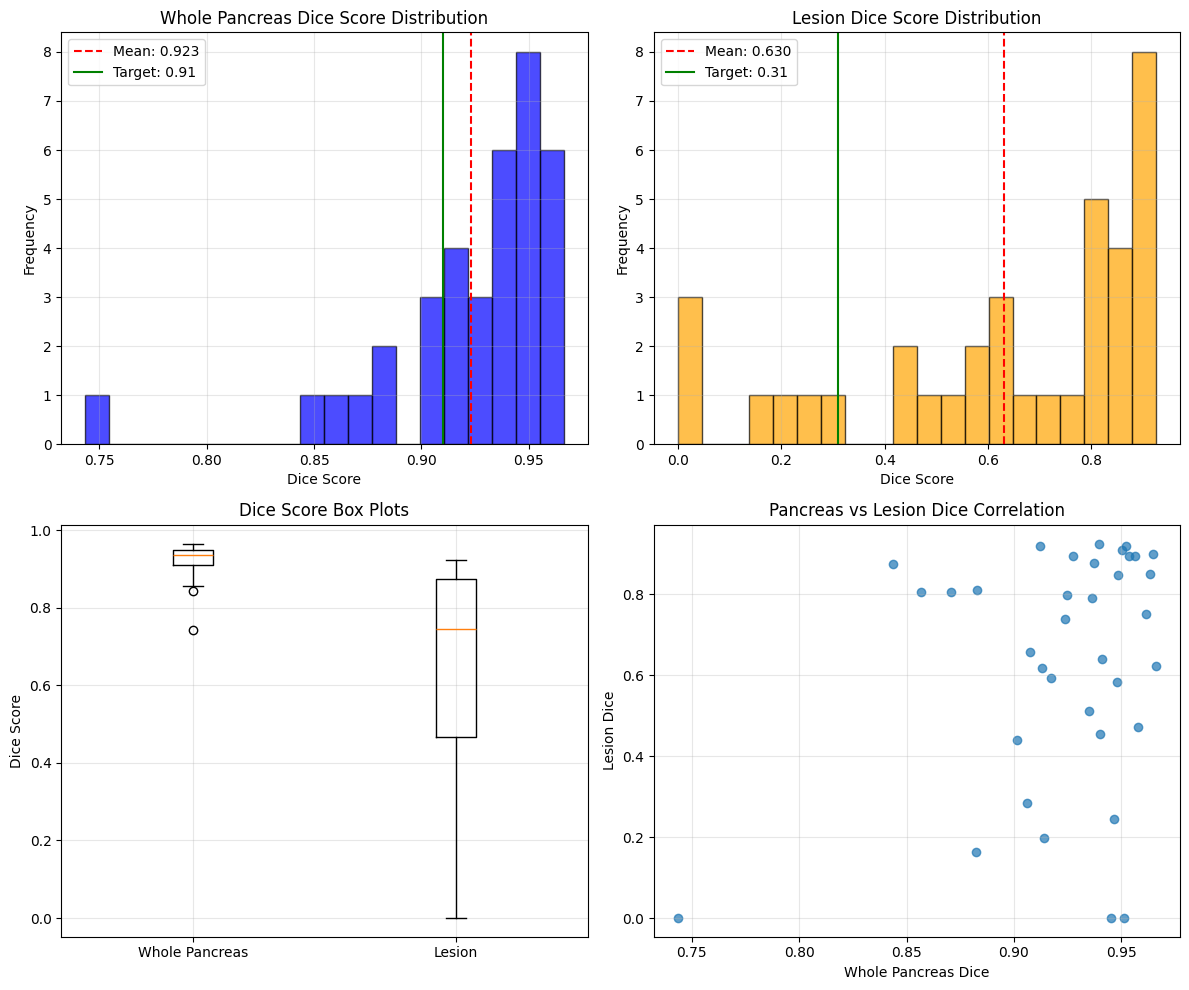


DETAILED STATISTICS:
       pancreas_dice  lesion_dice
count      36.000000    36.000000
mean        0.922845     0.630146
std         0.043554     0.291702
min         0.743417     0.000000
25%         0.911064     0.467487
50%         0.936868     0.745207
75%         0.950511     0.874962
max         0.966181     0.924870


In [17]:
if len(seg_results_df) > 0:
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Dice score distributions
    axes[0, 0].hist(seg_results_df['pancreas_dice'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(seg_results_df['pancreas_dice'].mean(), color='red', linestyle='--',
                       label=f'Mean: {seg_results_df["pancreas_dice"].mean():.3f}')
    axes[0, 0].axvline(0.91, color='green', linestyle='-', label='Target: 0.91')
    axes[0, 0].set_title('Whole Pancreas Dice Score Distribution')
    axes[0, 0].set_xlabel('Dice Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(seg_results_df['lesion_dice'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 1].axvline(seg_results_df['lesion_dice'].mean(), color='red', linestyle='--',
                       label=f'Mean: {seg_results_df["lesion_dice"].mean():.3f}')
    axes[0, 1].axvline(0.31, color='green', linestyle='-', label='Target: 0.31')
    axes[0, 1].set_title('Lesion Dice Score Distribution')
    axes[0, 1].set_xlabel('Dice Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Box plots
    dice_data = [seg_results_df['pancreas_dice'], seg_results_df['lesion_dice']]
    axes[1, 0].boxplot(dice_data, labels=['Whole Pancreas', 'Lesion'])
    axes[1, 0].set_title('Dice Score Box Plots')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Scatter plot
    axes[1, 1].scatter(seg_results_df['pancreas_dice'], seg_results_df['lesion_dice'], alpha=0.7)
    axes[1, 1].set_xlabel('Whole Pancreas Dice')
    axes[1, 1].set_ylabel('Lesion Dice')
    axes[1, 1].set_title('Pancreas vs Lesion Dice Correlation')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / 'segmentation_results_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print some statistics
    print("\nDETAILED STATISTICS:")
    print(seg_results_df[['pancreas_dice', 'lesion_dice']].describe())

In [18]:
def evaluate_classification_performance(pred_csv_path):
    """Evaluate classification performance"""

    if not Path(pred_csv_path).exists():
        print(f"Classification predictions file not found: {pred_csv_path}")
        print("Please create a CSV file with columns: ['Names', 'Subtype']")
        return None

    if gt_csv_path is None:
        print("Ground truth CSV not available")
        return None

    # Load ground truth and predictions
    gt_df = pd.read_csv(gt_csv_path)
    pred_df = pd.read_csv(pred_csv_path)

    print(f"Ground truth shape: {gt_df.shape}")
    print(f"Predictions shape: {pred_df.shape}")

    # Merge on case names
    merged = pd.merge(gt_df, pred_df, on='Names', suffixes=('_gt', '_pred'))
    print(f"Merged shape: {merged.shape}")

    if len(merged) == 0:
        print("No matching cases found between ground truth and predictions")
        return None

    y_true = merged['Subtype_gt'].values
    y_pred = merged['Subtype_pred'].values

    # Compute metrics
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    # Detailed classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    print("\n" + "="*60)
    print("CLASSIFICATION RESULTS SUMMARY")
    print("="*60)
    print(f"Number of cases: {len(merged)}")
    print(f"Macro-average F1: {macro_f1:.4f}")
    print(f"Micro-average F1: {micro_f1:.4f}")
    print(f"Weighted-average F1: {weighted_f1:.4f}")

    print("\nPer-class results:")
    for class_id in ['0', '1', '2']:
        if class_id in report:
            f1 = report[class_id]['f1-score']
            precision = report[class_id]['precision']
            recall = report[class_id]['recall']
            support = report[class_id]['support']
            print(f"  Subtype {class_id}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f}, N={support}")

    # Check targets
    print("\n" + "="*60)
    print("TARGET ASSESSMENT - CLASSIFICATION")
    print("="*60)

    f1_target = 0.7
    f1_met = macro_f1 >= f1_target

    print(f"Macro F1 >= {f1_target}: {'✓' if f1_met else '✗'} ({macro_f1:.4f})")

    results = {
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'classification_report': report,
        'num_cases': len(merged),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
    }

    # Save results
    with open(Path(OUTPUT_DIR) / 'classification_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    return results, merged

# Example usage - MODIFY THE PATH TO YOUR CLASSIFICATION PREDICTIONS
classification_pred_csv = "./subtype_results.csv"  # UPDATE THIS PATH

if Path(classification_pred_csv).exists():
    class_results, class_merged_df = evaluate_classification_performance(classification_pred_csv)
else:
    print(f"Classification predictions not found at: {classification_pred_csv}")
    print("Please provide the path to your classification results CSV file")
    class_results = None

Classification predictions not found at: ./subtype_results.csv
Please provide the path to your classification results CSV file


In [20]:
if class_results is not None:
    # Create confusion matrix plot
    y_true = class_merged_df['Subtype_gt'].values
    y_pred = class_merged_df['Subtype_pred'].values

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Subtype 0', 'Subtype 1', 'Subtype 2'],
                yticklabels=['Subtype 0', 'Subtype 1', 'Subtype 2'])
    plt.title('Classification Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(Path(OUTPUT_DIR) / 'classification_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=['Subtype 0', 'Subtype 1', 'Subtype 2']))

In [19]:
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)

# Segmentation summary
if len(seg_results_df) > 0:
    print("\nSEGMENTATION PERFORMANCE:")
    print(f"  Whole pancreas DSC: {seg_results_df['pancreas_dice'].mean():.4f} ± {seg_results_df['pancreas_dice'].std():.4f}")
    print(f"  Lesion DSC: {seg_results_df['lesion_dice'].mean():.4f} ± {seg_results_df['lesion_dice'].std():.4f}")

# Classification summary
if class_results is not None:
    print(f"\nCLASSIFICATION PERFORMANCE:")
    print(f"  Macro F1-score: {class_results['macro_f1']:.4f}")
    print(f"  Micro F1-score: {class_results['micro_f1']:.4f}")

# Target assessment
print("\n" + "="*70)
print("TARGET ACHIEVEMENT (Master Level)")
print("="*70)

targets_met = []

if len(seg_results_df) > 0:
    pancreas_target = 0.91
    lesion_target = 0.31

    pancreas_met = seg_results_df['pancreas_dice'].mean() >= pancreas_target
    lesion_met = seg_results_df['lesion_dice'].mean() >= lesion_target

    print(f"✓ Whole pancreas DSC >= {pancreas_target}: {'PASS' if pancreas_met else 'FAIL'} "
          f"({seg_results_df['pancreas_dice'].mean():.4f})")
    print(f"✓ Lesion DSC >= {lesion_target}: {'PASS' if lesion_met else 'FAIL'} "
          f"({seg_results_df['lesion_dice'].mean():.4f})")

    targets_met.extend([pancreas_met, lesion_met])

if class_results is not None:
    f1_target = 0.7
    f1_met = class_results['macro_f1'] >= f1_target

    print(f"✓ Macro F1 >= {f1_target}: {'PASS' if f1_met else 'FAIL'} "
          f"({class_results['macro_f1']:.4f})")

    targets_met.append(f1_met)

if targets_met:
    all_met = all(targets_met)
    print(f"\n🎯 ALL MASTER-LEVEL TARGETS MET: {'YES! 🎉' if all_met else 'NOT YET 📈'}")
else:
    print("\n⚠️  No evaluation results available")

print(f"\nResults saved to: {Path(OUTPUT_DIR).absolute()}")


FINAL PERFORMANCE SUMMARY

SEGMENTATION PERFORMANCE:
  Whole pancreas DSC: 0.9228 ± 0.0436
  Lesion DSC: 0.6301 ± 0.2917

TARGET ACHIEVEMENT (Master Level)
✓ Whole pancreas DSC >= 0.91: PASS (0.9228)
✓ Lesion DSC >= 0.31: PASS (0.6301)

🎯 ALL MASTER-LEVEL TARGETS MET: YES! 🎉

Results saved to: /mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_results/val_predictions/evaluation_results


## Measure the baseline inference speed
```bash
    === BENCHMARK SUMMARY ===
    Successful cases: 5/5
    Total inferences: 15
    Mean inference time: 1.2917s
    Median inference time: 1.3130s
    Std deviation: 0.5575s
    Results saved to /mnt/data/gpu-server/nnUNet_modified/nnunet_data/nnUNet_results/Dataset001_PancreasSegClassification/nnUNetTrainer__nnUNetPlans__3d_fullres/speed_benchmark_results.json
```